In [ ]:
## Data Cleaning ##
# Import libraries
import pandas as pd
# Reading File
df = pd.read_csv('/content/drive/MyDrive/sales_data_sample.csv', encoding='latin-1')
#change date type
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
# Remove unnecessary cols
df['CONTACTNAME'] = df['CONTACTFIRSTNAME'] + ' ' + df['CONTACTLASTNAME']
df = df.drop(['ADDRESSLINE2','POSTALCODE', 'PHONE'], axis=1)
#replace null/missing values
df['TERRITORY'] = df['TERRITORY'].fillna('Na')
df['STATE'] = df['STATE'].fillna(df['CITY'])
# Combine "Vintage Cars" and "Classic Cars" into a single category
df['PRODUCTLINE'] = df['PRODUCTLINE'].replace(['Vintage Cars', 'Classic Cars'], 'Cars')

# Save DataFrame to CSV
df.to_csv('sample_data.csv', index=False)
from google.colab import files

# Download the file
files.download('sample_data.csv')


KeyError: 'CONTACTFIRSTNAME'

In [ ]:
##Data Analysis and Visualization##
#customer segmentation#

# Aggregate data to get purchase frequency and total spend per customer
customer_data = df.groupby('CUSTOMERNAME').agg({
    'ORDERNUMBER': 'nunique',  #  Number of unique orders
    'SALES': 'sum'             #  Total spend
}).reset_index()

# Rename columns for clarity
customer_data.columns = ['CustomerName', 'PurchaseFrequency', 'TotalSpend']
freq = customer_data['PurchaseFrequency'].quantile(0.5)
spend = customer_data['TotalSpend'].quantile(0.5)

# Define thresholds for high value customers
def segment_customer (row, freq, spend):
    if row['PurchaseFrequency'] > freq and row['TotalSpend'] > spend:
        return 'High Value'
    elif row['PurchaseFrequency'] > freq and row['TotalSpend'] <= spend:
        return 'High Frequency'
    elif row['PurchaseFrequency'] <= freq and row['TotalSpend'] > spend:
        return 'High Spend'
    else:
        return 'Low Value'

customer_data['Segment'] = customer_data.apply(segment_customer, axis=1, args=(freq, spend))


print(customer_data.head())



              CustomerName  PurchaseFrequency  TotalSpend     Segment
0           AV Stores, Co.                  3   157807.81  High Spend
1             Alpha Cognac                  3    70488.44   Low Value
2       Amica Models & Co.                  2    94117.26  High Spend
3  Anna's Decorations, Ltd                  4   153996.13  High Value
4        Atelier graphique                  3    24179.96   Low Value


In [ ]:
segment_counts = customer_data['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']
print(segment_counts)

          Segment  Count
0       Low Value     43
1      High Spend     27
2      High Value     19
3  High Frequency      3


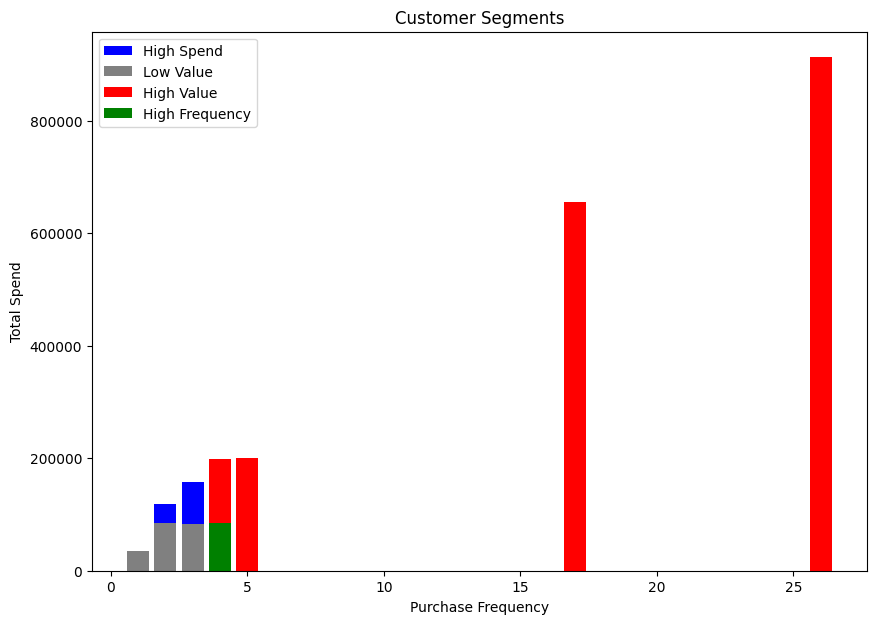

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
#
plt.figure(figsize=(10, 7))
colors = {'High Value': 'red', 'High Frequency': 'green', 'High Spend': 'blue', 'Low Value': 'gray'}
for segment in customer_data['Segment'].unique():
    plt.bar(customer_data.loc[customer_data['Segment'] == segment, 'PurchaseFrequency'],
                customer_data.loc[customer_data['Segment'] == segment, 'TotalSpend'],
                color=colors[segment], label=segment)
plt.title('Customer Segments')
plt.xlabel('Purchase Frequency')
plt.ylabel('Total Spend')
plt.legend()
plt.show()


In [ ]:
#calculate CLTV#

# Calculate the total revenue per customer
total_revenue_per_customer = df.groupby('CUSTOMERNAME')['SALES'].sum().reset_index()
total_revenue_per_customer.columns = ['Customer', 'TotalRevenue']

# Calculate the number of orders per customer
orders_per_customer = df.groupby('CUSTOMERNAME')['ORDERNUMBER'].nunique().reset_index()
orders_per_customer.columns = ['Customer', 'OrderCount']

# Merge total revenue and order count dataframes
customer_data = pd.merge(total_revenue_per_customer, orders_per_customer, on='Customer')

# Calculate average order value
customer_data['AverageOrderValue'] = customer_data['TotalRevenue'] / customer_data['OrderCount']

# Calculate the first and last purchase dates for each customer
purchase_dates = df.groupby('CUSTOMERNAME')['ORDERDATE'].agg(['min', 'max']).reset_index()
purchase_dates.columns = ['Customer', 'FirstPurchaseDate', 'LastPurchaseDate']

# Calculate customer lifespan in days
purchase_dates['CustomerLifespanDays'] = (purchase_dates['LastPurchaseDate'] - purchase_dates['FirstPurchaseDate']).dt.days

# Merge with customer data
customer_data = pd.merge(customer_data, purchase_dates[['Customer', 'CustomerLifespanDays']], on='Customer')

# Calculate purchase frequency (orders per customer)
purchase_frequency = df['ORDERNUMBER'].nunique() / df['CUSTOMERNAME'].nunique()

# Calculate CLTV
customer_data['CLTV'] = customer_data['AverageOrderValue'] * purchase_frequency * customer_data['CustomerLifespanDays']

# Display only the Customer and CLTV columns
cltv_data = customer_data[['Customer', 'CLTV']]
top_n_customers = cltv_data.sort_values(by='CLTV', ascending=False).head(20)
last_n_customers = cltv_data.sort_values(by='CLTV', ascending=True).head(20)

# Display the result
print(cltv_data.head())


                  Customer          CLTV
0           AV Stores, Co.  1.070749e+08
1             Alpha Cognac  4.963076e+07
2       Amica Models & Co.  3.611750e+06
3  Anna's Decorations, Ltd  7.001593e+07
4        Atelier graphique  1.492718e+07


In [ ]:
#average cltv#
average_cltv = cltv_data['CLTV'].mean()
print(f"The average Customer Lifetime Value (CLTV) is: {average_cltv}")

The average Customer Lifetime Value (CLTV) is: 45382967.15964366


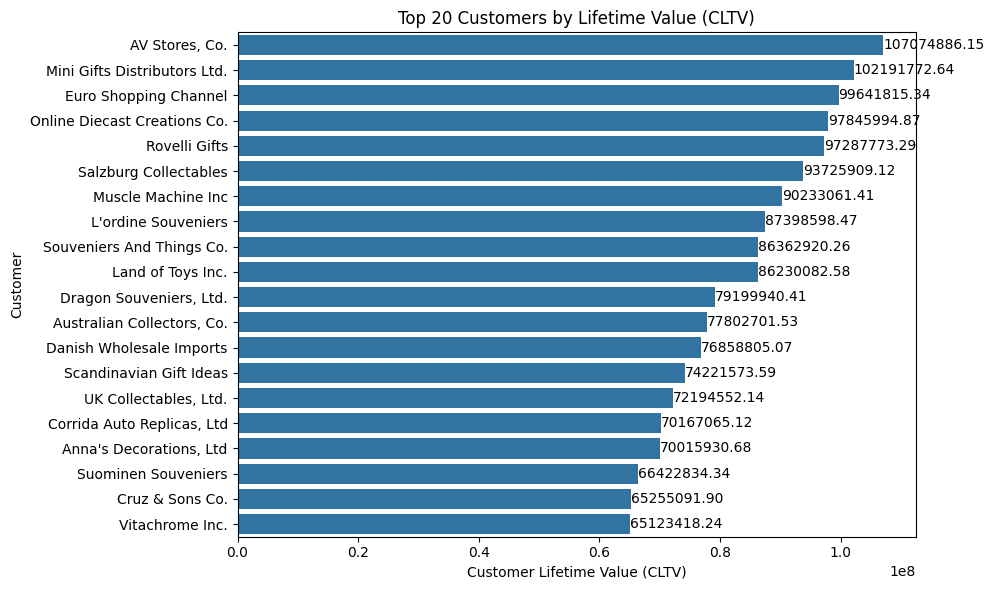

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(y='Customer', x='CLTV', data=top_n_customers)
for i, value in enumerate(top_n_customers['CLTV']):
    plt.text(value, i, f'{value:.2f}', va='center')
plt.xlabel('Customer Lifetime Value (CLTV)')
plt.ylabel('Customer')
plt.title('Top 20 Customers by Lifetime Value (CLTV)')
plt.tight_layout()
plt.show()

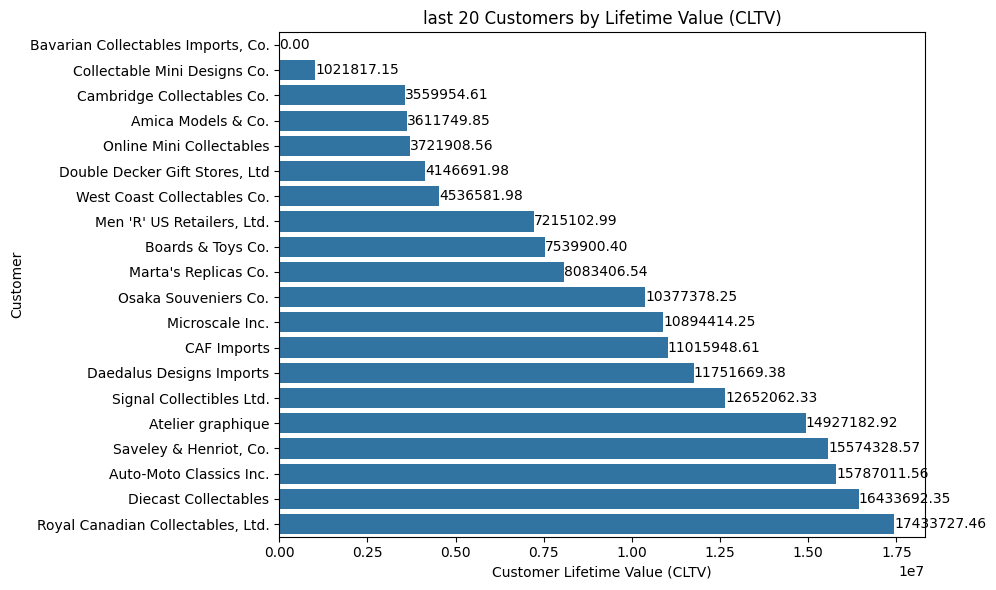

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(y='Customer', x='CLTV', data=last_n_customers)
for i, value in enumerate(last_n_customers['CLTV']):
    plt.text(value, i, f'{value:.2f}', va='center')
plt.xlabel('Customer Lifetime Value (CLTV)')
plt.ylabel('Customer')
plt.title('last 20 Customers by Lifetime Value (CLTV)')
plt.tight_layout()
plt.show()

   YEAR_ID  MONTH_ID      SALES
0     2003         1  129753.60
1     2003         2  140836.19
2     2003         3  174504.90
3     2003         4  201609.55
4     2003         5  192673.11
   YEAR_ID  QTR_ID       SALES
0     2003       1   445094.69
1     2003       2   562365.22
2     2003       3   649514.54
3     2003       4  1860005.09
4     2004       1   833730.68


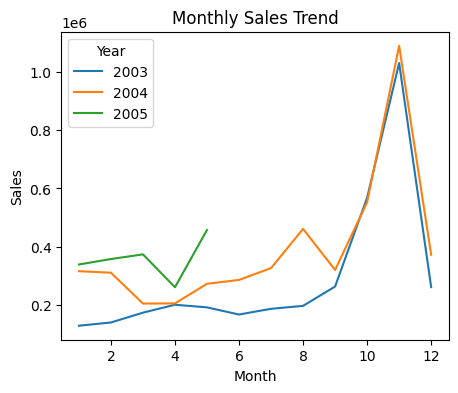

In [ ]:
#Analyze trends over time#
# Aggregate data by month and year
monthly_sales = df.groupby(['YEAR_ID', 'MONTH_ID']).agg({
    'SALES': 'sum'
}).reset_index()

# Aggregate data by quarter and year
quarterly_sales = df.groupby(['YEAR_ID', 'QTR_ID']).agg({
    'SALES': 'sum'
}).reset_index()

print(monthly_sales.head())
print(quarterly_sales.head())

# Create a pivot table for easier plotting
monthly_sales_pivot = monthly_sales.pivot(index='MONTH_ID', columns='YEAR_ID', values='SALES')

# Plot the monthly sales trend
monthly_sales_pivot.plot(figsize=(5, 4))
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(title='Year')
plt.show()


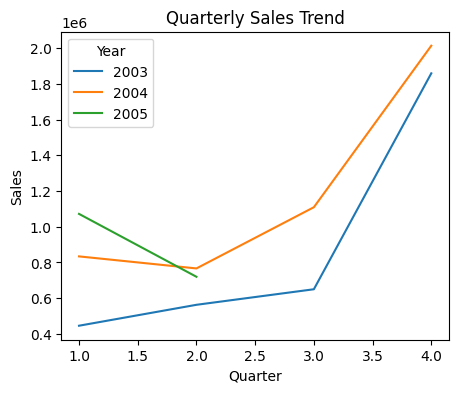

In [ ]:
# Create a pivot table for easier plotting
quarterly_sales_pivot = quarterly_sales.pivot(index='QTR_ID', columns='YEAR_ID', values='SALES')

# Plot the quarterly sales trend
quarterly_sales_pivot.plot(figsize=(5, 4))
plt.title('Quarterly Sales Trend')
plt.xlabel('Quarter')
plt.ylabel('Sales')
plt.legend(title='Year')
plt.show()


In [ ]:
#Product Line Sales Distribution#

# Group by product line and calculate total sales
product_line_sales = df.groupby('PRODUCTLINE').agg({'SALES': 'sum'}).reset_index()

plt.figure(figsize=(5, 4))
plt.bar(product_line_sales['PRODUCTLINE'], product_line_sales['SALES'], color='skyblue')
plt.title('Product Line Sales Distribution')
plt.xlabel('Product Line')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()


NameError: name 'plt' is not defined

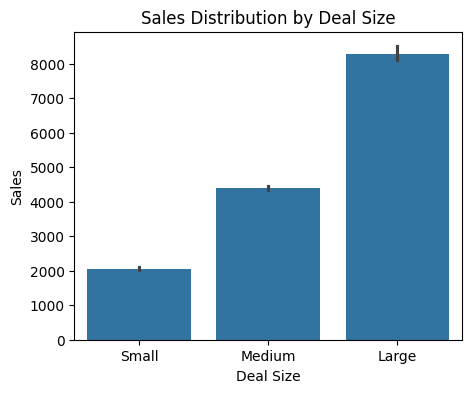

In [ ]:
plt.figure(figsize=(5, 4))
sns.barplot(x='DEALSIZE', y='SALES', data=df)
plt.title('Sales Distribution by Deal Size')
plt.xlabel('Deal Size')
plt.ylabel('Sales')
plt.show()


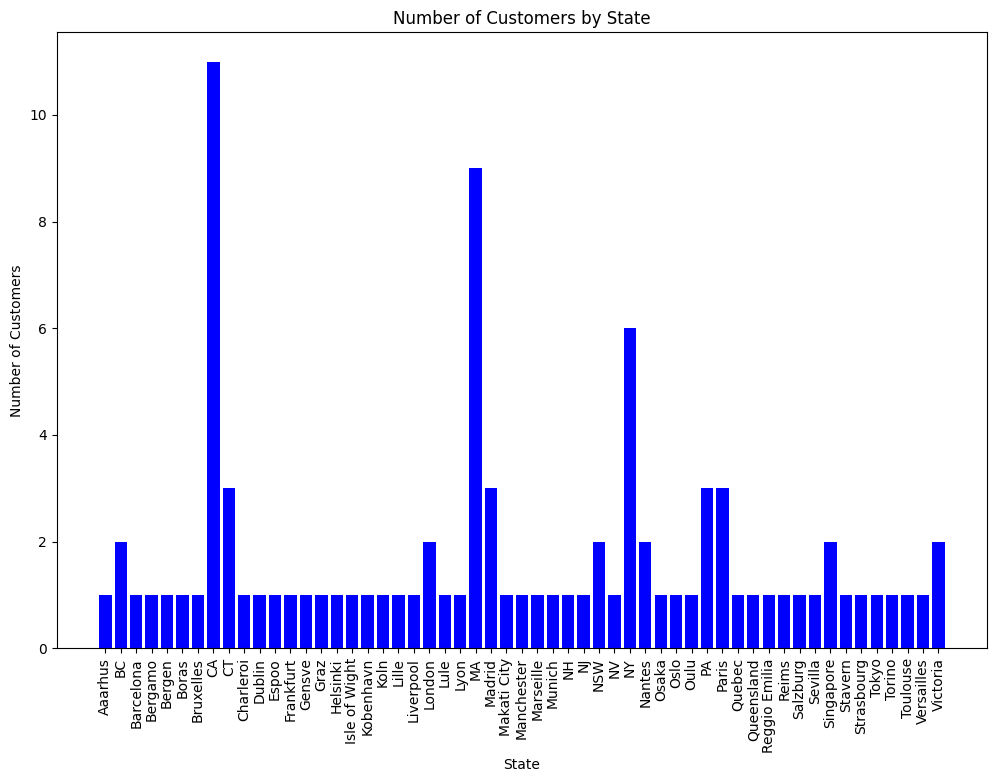

In [ ]:
customers_by_state = df.groupby('STATE').agg({'CUSTOMERNAME': 'nunique'}).reset_index()
customers_by_state.columns = ['State', 'Number of Customers']

plt.figure(figsize=(12, 8))
plt.bar(customers_by_state['State'], customers_by_state['Number of Customers'], color='blue')
plt.title('Number of Customers by State')
plt.xlabel('State')
plt.ylabel('Number of Customers')
plt.xticks(rotation=90)
plt.show()
